In [1]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt
import deepinv as dinv
import torch
from deepinv.utils.demo import load_url_image
import scipy
import skimage as ski
from skimage.transform import rescale, resize, downscale_local_mean

/Users/chaz/miniconda3/envs/deepinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


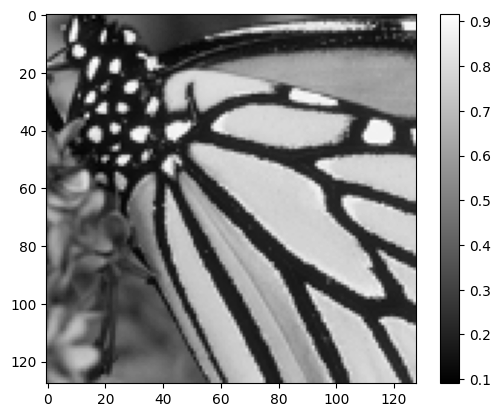

In [2]:
# image = resize(ski.util.img_as_float(ski.io.imread("05.png")), (128,128))[28:,28:]
image = resize(ski.util.img_as_float(ski.io.imread("05.png"))[56:,56:], (128,128))
# image = ski.util.img_as_float(ski.io.imread("05.png"))[56:,56:]
x_true = image.flatten()
dim = image.shape[0]
plt.imshow(image, cmap="gray")
plt.colorbar()

In [3]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

True image shape: (16384,)


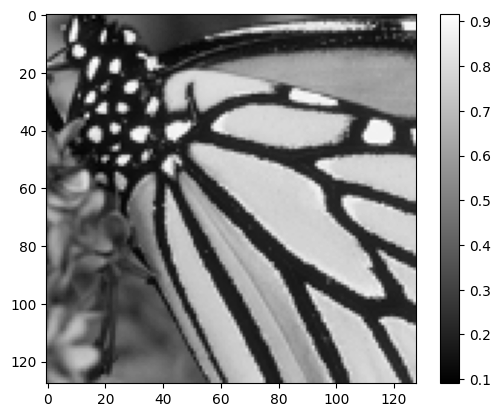

In [4]:
plt.imshow(x_true.reshape(dim,dim), cmap="gray")
plt.colorbar()
print("True image shape:", x_true.shape)

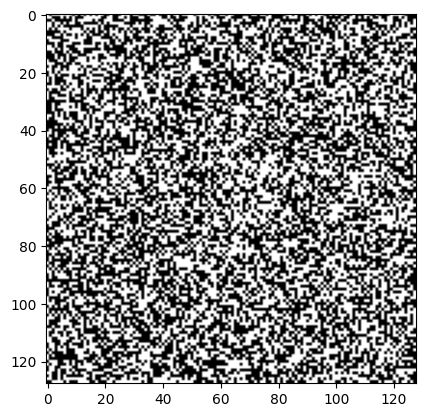

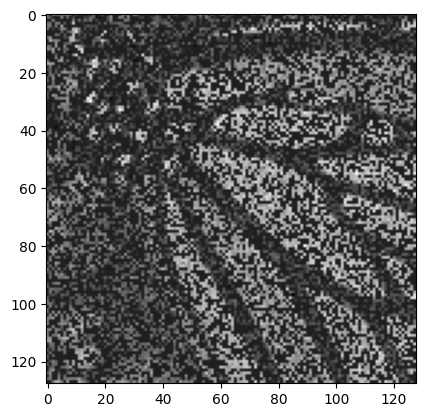

In [5]:
# define forward operator and create data
np.random.seed(1)
# 1. manual mask
zero_density = 0.5#0.9#0.5#0.8#0.7   # we keep 70% of the pixels
mask_vector = np.random.random(size=dim**2) < zero_density
# convert mask_vector to a vector of 0s and 1s
mask_vector = mask_vector.astype(int)
# mask = np.diag(mask_vector)
mask = scipy.sparse.diags(mask_vector)
# # 2. mask imported from deepinv
# mask_vector = np.load("mask.npy")  # load a pre-defined mask
# mask_vector = mask_vector.flatten()
# mask = np.diag(mask_vector)
y_exact = x_true @ mask

noise_std = 0.1 # half noise
# 1. manual noise
y_obs = y_exact + np.random.normal(0, noise_std, size=y_exact.shape)@mask
# # 2. imported y_obs
# y_obs = np.load("y_obs.npy").flatten()  # load a pre-defined observation

plt.imshow(mask_vector.reshape(dim, dim), cmap='gray')
plt.figure()
plt.imshow(y_obs.reshape(dim, dim), cmap='gray')

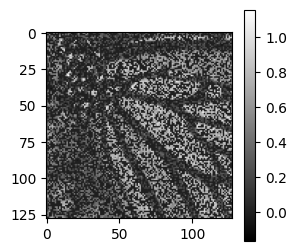

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(y_obs.reshape(dim, dim), cmap='gray')
plt.colorbar()

In [7]:
# tweak denoiser
sigma_denoiser = 0.01#0.1#0.01#0.02#0.01#0.3#2 / 255
# denoiser=dinv.models.DnCNN(pretrained="download_lipschitz", in_channels=1, out_channels=1)
# denoiser=dinv.models.DRUNet(pretrained="download", in_channels=1, out_channels=1)

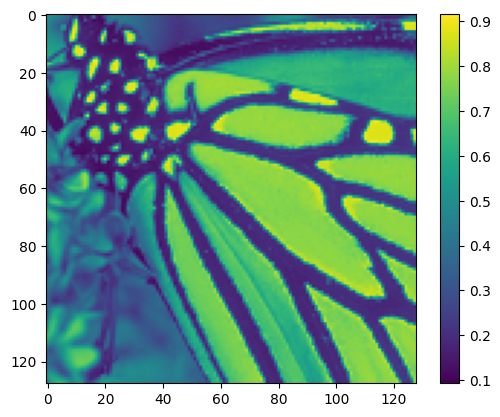

In [8]:
plt.imshow(ski.restoration.denoise_wavelet(x_true.reshape(dim, dim), sigma=sigma_denoiser, wavelet="haar", wavelet_levels=1))
plt.colorbar()

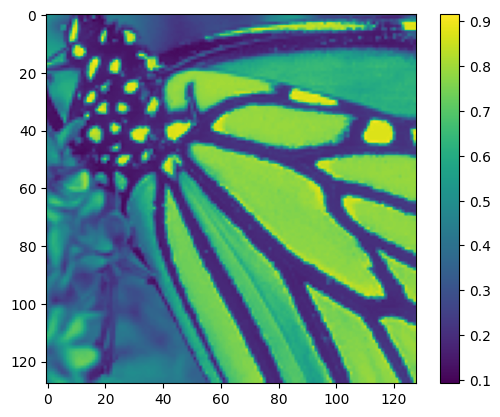

In [9]:
plt.imshow(ski.restoration.denoise_wavelet(x_true.reshape(dim, dim), sigma=sigma_denoiser, wavelet="haar", wavelet_levels=3))
plt.colorbar()

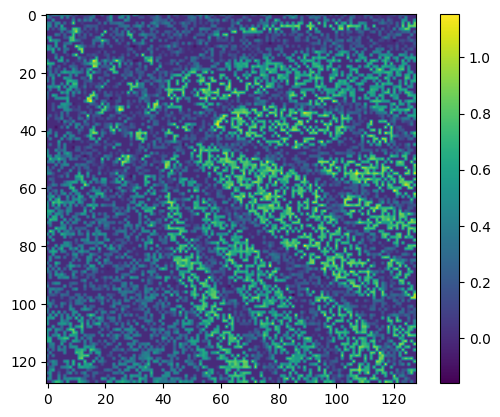

In [10]:
plt.imshow(ski.restoration.denoise_wavelet(y_obs.reshape(dim, dim), sigma=sigma_denoiser, wavelet="haar"))
plt.colorbar()

In [11]:
def nn_denoiser(x, restoration_strength=None):
    result = ski.restoration.denoise_wavelet(x.reshape(dim, dim), wavelet="haar", sigma=10*sigma_denoiser).reshape(dim*dim) #, wavelet="haar" #, sigma=sigma_denoiser #, sigma=1e-2
    # with torch.no_grad():
    #     result = denoiser.forward(torch.tensor(x.reshape(1,1,dim,dim), dtype=torch.float32), sigma=sigma_denoiser).detach().reshape(dim*dim).numpy()
    return result, None

In [12]:
restorator=cuqi.implicitprior.RestorationPrior(
    nn_denoiser,
    restorator_kwargs={},
    geometry=cuqi.geometry.Image2D((dim, dim), visual_only=True),
)

In [13]:
myprior = cuqi.implicitprior.MoreauYoshidaPrior(restorator, sigma_denoiser) # #0.4 #0.5 #0.3 #0.05 #**2 #0.5*sigma_denoiser*sigma_denoiser

In [14]:
# forward, likelihood
forward = cuqi.model.LinearModel(mask, domain_geometry=restorator.geometry, range_geometry=restorator.geometry)

prec = scipy.sparse.diags(np.ones(dim**2) / noise_std**2)  # sparse diagonal matrix
y = cuqi.distribution.Gaussian(forward@myprior, prec=prec)

In [15]:
def check_sample_fun(sample, i):
    if i % 1000 == 0:
        # save image
        plt.imsave(f"samples_wavelet/{i}.png", sample.reshape(dim, dim), cmap='gray')

In [16]:
# post.gradient(np.zeros(dim**2))  # just to check that the prior is defined

In [17]:
# post = cuqi.distribution.JointDistribution(restorator, y)(y=y_obs)
post = cuqi.distribution.JointDistribution(myprior, y)(y=y_obs)
step_size = 1e-2 #1e-2
# step_size = 0.1*0.01 * (noise_std**2) * 2 # 2.5e-05 # is multiplied by 2 so be the same scaling as in deepinv ## note it is scaled by 0.1 now compared to deepinv
# x_initial = np.load("x_inital.npy").flatten()  # load a pre-defined initial guess
x_initial = y_obs.copy()
# sampler = cuqi.experimental.mcmc.PnPULA(post, scale=step_size, smoothing_strength=sigma_denoiser, initial_point=x_initial)
sampler = cuqi.experimental.mcmc.ULA(post, scale=step_size, initial_point=x_initial, callback=check_sample_fun) #, callback=check_sample_fun
sampling_steps = 60000#60000
warmup_steps = 60000#40000
np.random.seed(0)  # for reproducibility
sampler.warmup(warmup_steps)
sampler.sample(sampling_steps)

Sample: 100%|██████████| 60000/60000 [02:52<00:00, 347.01it/s, acc rate: 100.00%]


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(myprior|y) ∝ L(myprior|y)p(myprior)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['myprior'].
 	myprior ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [0.57753979 0.4778415  0.50121438 ... 1.13270793 0.30297588 0.89124292] 
	 current_target_grad: [ 0.69199434 -0.99300547 -2.42558984 ... -7.9990001   2.75146416
  1.41541585] 
	 scale: 0.01 

In [18]:
# # sampling_steps = 60000
# sampling_steps = 600000#00#0#0
# warmup_steps = 40#000
# np.random.seed(0)  # for reproducibility
# # _ = sampler.warmup(warmup_steps)
# all_samples_list = []
# # all_samples_list.append(sampler.get_samples().samples)
# sampler._samples = []
# N_batches = 1000
# thinning = 200#200
# for batch_idx in range(N_batches):
#     print(f'batch number {batch_idx} of {N_batches}')
#     _ = sampler.sample(int(sampling_steps/N_batches))
#     samples_batch = sampler.get_samples()
#     all_samples_list.append(samples_batch.burnthin(Nb=0, Nt=thinning).samples)
#     #sampler.save_checkpoint('checkpoint_'+expr_tag+'.pickle')
#     #sampler.reset()
#     #sampler.load_checkpoint('checkpoint_'+expr_tag+'.pickle')
#     sampler._samples = []

# all_samples_array = np.concatenate(all_samples_list, axis=1)
# samples = cuqi.samples.Samples(all_samples_array) 

In [19]:
# samples

In [20]:
thinning = 10  # thinning factor
samples = sampler.get_samples().burnthin(warmup_steps, thinning)

In [21]:
# samples = np.load("butterfly_samples_wavelet.npy", allow_pickle=True).item()

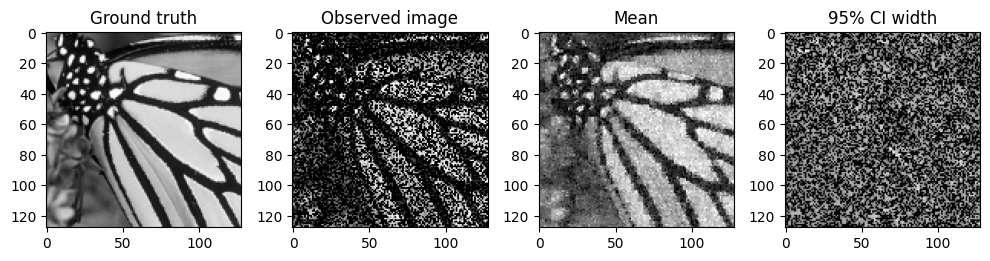

In [22]:
vmin = 0.1#-0.1
vmax = 0.9#1.1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
ax1.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Ground truth')
ax2.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax2.set_title('Observed image')
ax3.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax3.set_title('Mean')
ax4.imshow(samples.ci_width().reshape(dim, dim), cmap='gray')
ax4.set_title('95% CI width')
plt.tight_layout()
plt.savefig("comparision_wavelet.pdf")

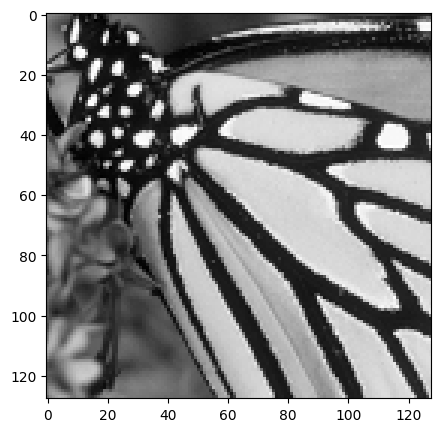

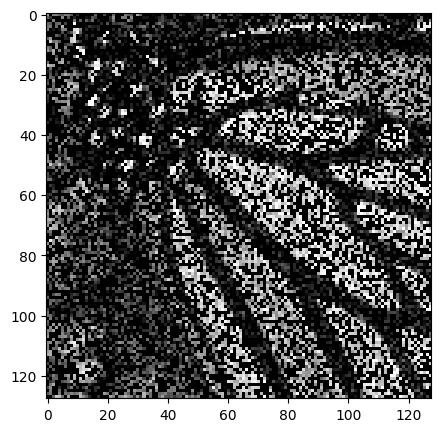

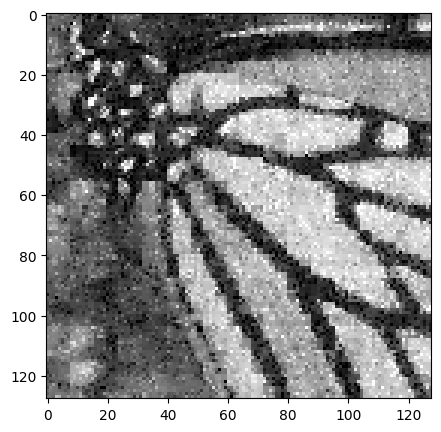

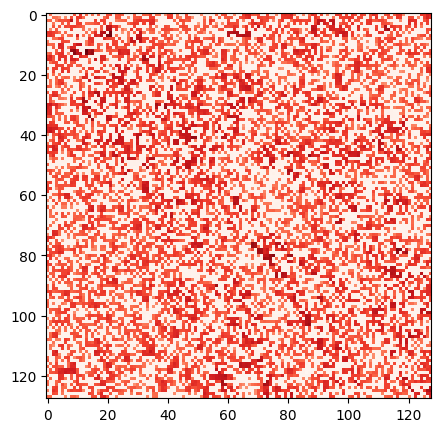

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("groundthruth_wavelet.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("data_wavelet.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
plt.savefig("mean_wavelet.pdf", bbox_inches='tight')
fig, ax = plt.subplots(figsize=(10, 5))
a = ax.imshow(samples.ci_width().reshape(dim, dim), cmap='Reds')
# plt.colorbar(a)
plt.savefig("ci_width_wavelet.pdf", bbox_inches='tight')

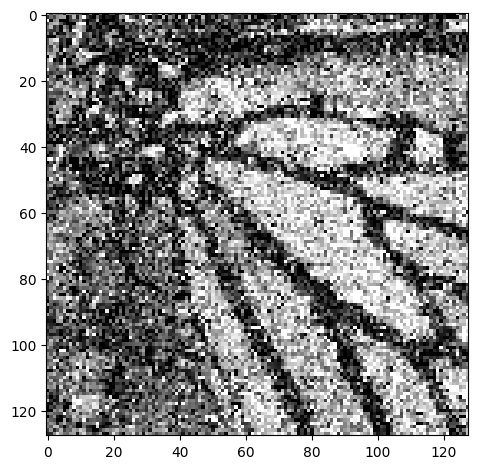

In [24]:
samples.geometry = cuqi.geometry.Image2D((dim, dim))
samples.plot(-1, vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.savefig("one_sample_wavelet.pdf")

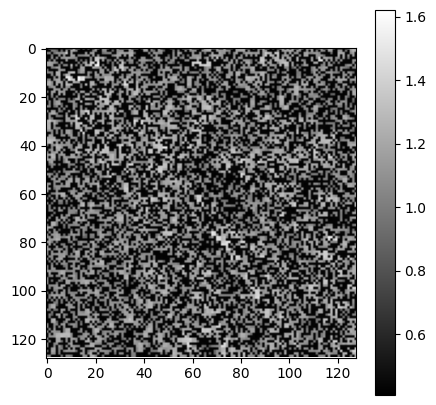

In [25]:
samples.plot_ci_width(cmap='gray')
# get fig of the last plot
plt.gcf().set_size_inches(5,5)
plt.title("")
plt.colorbar()
plt.savefig("ci_width_wavelet2.pdf")

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v422'}>,
        <Axes: title={'center': 'v422'}>],
       [<Axes: title={'center': 'v7699'}>,
        <Axes: title={'center': 'v7699'}>],
       [<Axes: title={'center': 'v10609'}>,
        <Axes: title={'center': 'v10609'}>],
       [<Axes: title={'center': 'v14771'}>,
        <Axes: title={'center': 'v14771'}>],
       [<Axes: title={'center': 'v15587'}>,
        <Axes: title={'center': 'v15587'}>]], dtype=object)

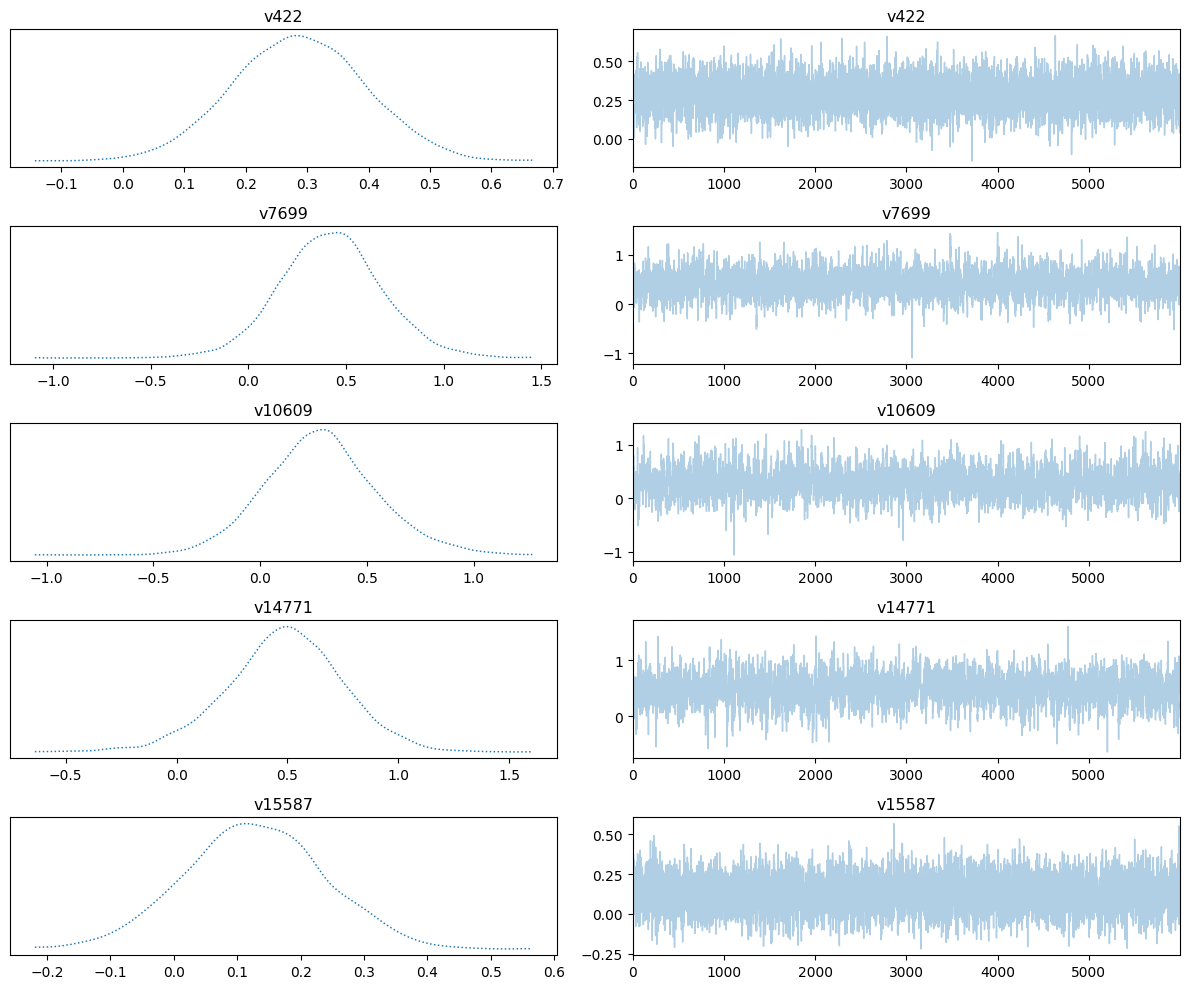

In [26]:
samples.plot_trace()

In [27]:
np.save("butterfly_samples_wavelet.npy", samples)

# check variance and mask

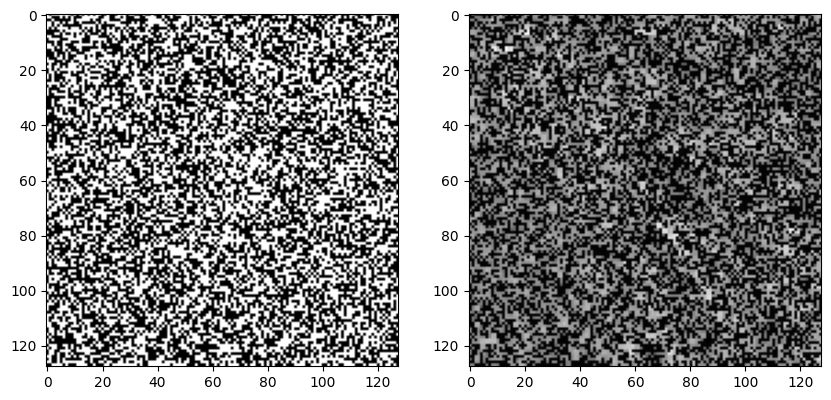

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(mask_vector.reshape(dim, dim), cmap='gray')
axs[1].imshow(samples.ci_width().reshape(dim, dim), cmap='gray')

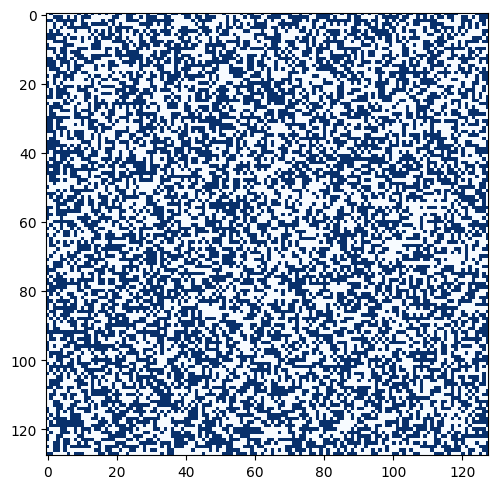

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(mask_vector.reshape(dim, dim), cmap='Blues_r')
plt.tight_layout()
plt.savefig("mask.pdf", bbox_inches='tight')